# ERC-4626: vault report

- This is the same as [ERC-4626 best vaults](./erc4626-best-vaults.html) notebook, but tailored for the blog post output
- The output is condensed with less charts, lists and data points
- Tables are outputted as Markdown for copy-paste and the rendering is left to the blog engine
- Vaults are ranked by 1M returns unless noted otherwise

## Setup

- Set up notebook rendering output mode
- Use static image charts so this notebook is readeable on Github / ReadTheDocs

In [ ]:
import pandas as pd
from plotly.offline import init_notebook_mode
import plotly.io as pio

from eth_defi.research.notebook import set_large_plotly_chart_font


pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Set up Plotly chart output as SVG
image_format = "png"
width = 1400
height = 800

# https://stackoverflow.com/a/52956402/315168
init_notebook_mode()

# https://stackoverflow.com/a/74609837/315168
assert hasattr(pio, "kaleido"), "Kaleido rendering backend missing. Run 'pip install kaleido' needed for this notebook"
pio.kaleido.scope.default_format = image_format

# https://plotly.com/python/renderers/#overriding-the-default-renderer
pio.renderers.default = image_format

current_renderer = pio.renderers[image_format]
# Have SVGs default pixel with
current_renderer.width = width
current_renderer.height = height

# Set all Plotly charts to use large font sizes for better readability,
# for sharing on mobile
set_large_plotly_chart_font(line_width=5, legend_font_size=16)
pio.templates.default = "custom"

/var/folders/8n/h2dzh5yx5470cc6c_12dwrjw0000gn/T/ipykernel_94005/2453840123.py:21: DeprecationWarning:


Use of plotly.io.kaleido.scope.default_format is deprecated and support will be removed after September 2025.
Please use plotly.io.defaults.default_format instead.




Could not import set_large_plotly_chart_font() from tradeexecutor.utils.notebook and set large output font. 


## Read previously scanned vault price data

- Read the Parquet file produced earlier with price scan 

In [2]:
import pickle
from pathlib import Path

output_folder = Path("~/.tradingstrategy/vaults").expanduser()
parquet_file = output_folder / "vault-prices-1h.parquet"
assert parquet_file.exists(), "Run the vault scanner script first"

vault_db = output_folder / "vault-db.pickle"
assert vault_db.exists(), "Run the vault scanner script first"
vault_db = pickle.load(open(vault_db, "rb"))

try:
    prices_df = pd.read_parquet(parquet_file)
except Exception as e:
    raise RuntimeError(f"Could not read: {parquet_file}: {e}") from e

chains = prices_df["chain"].unique()

print(f"We have {len(prices_df):,} price rows and {len(vault_db)} vault metadata entries for {len(chains)} chains")

sample_vault = next(iter(vault_db.values()))
print("We have vault metadata keys: ", ", ".join(c for c in sample_vault.keys()))
display(pd.Series(sample_vault))

print("We have prices DataFrame columns: ", ", ".join(c for c in prices_df.columns))
print("DataFrame sample:")
display(prices_df.head())

We have 28,254,059 price rows and 10835 vault metadata entries for 18 chains
We have vault metadata keys:  Symbol, Name, Address, Denomination, NAV, Protocol, Mgmt fee, Perf fee, Shares, First seen, _detection_data, _denomination_token, _share_token


Symbol                                                             LWBTC
Name                                                               LWBTC
Address                       0x54805704a416a39bd36fc740194f9569e7e36b7c
Denomination                                                        WBTC
NAV                                                           0.00020323
Protocol                                              <unknown ERC-4626>
Mgmt fee                                                            None
Perf fee                                                            None
Shares                                                            0.0002
First seen                                           2022-07-14 22:46:51
_detection_data        ERC4262VaultDetection(chain=42161, address='0x...
_denomination_token    {'name': 'Wrapped BTC', 'symbol': 'WBTC', 'tot...
_share_token           {'name': 'LWBTC', 'symbol': 'LWBTC', 'total_su...
dtype: object

We have prices DataFrame columns:  chain, address, block_number, timestamp, share_price, total_assets, total_supply, performance_fee, management_fee, errors
DataFrame sample:


chain                                     address  block_number  \
0  42161  0x42448fddcec02124cf6db19a9f91dea7bb0e88e5      10832321   
1  42161  0x42448fddcec02124cf6db19a9f91dea7bb0e88e5      10846721   
2  42161  0x42448fddcec02124cf6db19a9f91dea7bb0e88e5      10861121   
3  42161  0x42448fddcec02124cf6db19a9f91dea7bb0e88e5      10875521   
4  42161  0x42448fddcec02124cf6db19a9f91dea7bb0e88e5      10889921   

            timestamp  share_price  total_assets  total_supply  \
0 2022-04-29 14:53:11          NaN          1.00           NaN   
1 2022-04-29 18:40:32          NaN      5,901.38           NaN   
2 2022-04-29 23:55:15          NaN      8,888.00           NaN   
3 2022-04-30 05:04:21          NaN      8,888.00           NaN   
4 2022-04-30 08:49:24          NaN      8,888.00           NaN   

   performance_fee  management_fee                    errors  
0              NaN             NaN  total_supply call failed  
1              NaN             NaN  total_supply call failed  
2              NaN             NaN  total_supply call failed  
3              NaN             NaN  total_supply call failed  
4              NaN             NaN  total_supply call failed

## Transform data

- Combine columns from metadata database with price series for easier manipulation

In [3]:
from eth_defi.chain import get_chain_name


vaults_by_id = {f"{vault['_detection_data'].chain}-{vault['_detection_data'].address}": vault for vault in vault_db.values()}

# We use name later as DF index, so we need to make sure they are unique
counter = 1
used_names = set()
for id, vault in vaults_by_id.items():
    # 40acres forgot to name their vault
    if vault["Name"] == "Vault":
        vault["Name"] == "40acres"

    if vault["Name"] in used_names:
        chain_name = get_chain_name(vault["_detection_data"].chain)
        vault["Name"] = f"{vault['Name']} ({chain_name}) #{counter}"
        counter += 1

    used_names.add(vault["Name"])

print(f"Fixed {counter} duplicate vault names")


# Vaults are identified by their chain and address tuple, make this one human-readable column
# to make DataFrame wrangling easier
prices_df["id"] = prices_df["chain"].astype(str) + "-" + prices_df["address"].astype(str)
prices_df["name"] = prices_df["id"].apply(lambda x: vaults_by_id[x]["Name"] if x in vaults_by_id else None)
prices_df["event_count"] = prices_df["id"].apply(lambda x: vaults_by_id[x]["_detection_data"].deposit_count + vaults_by_id[x]["_detection_data"].redeem_count)
prices_df["protocol"] = prices_df["id"].apply(lambda x: vaults_by_id[x]["Protocol"] if x in vaults_by_id else None)

# 40acres fix - they did not name their vault,
# More about this later
prices_df["name"] = prices_df["name"].fillna("<unknown>")


display(prices_df.head(1))

Fixed 4037 duplicate vault names


chain                                     address  block_number  \
0  42161  0x42448fddcec02124cf6db19a9f91dea7bb0e88e5      10832321   

            timestamp  share_price  total_assets  total_supply  \
0 2022-04-29 14:53:11          NaN          1.00           NaN   

   performance_fee  management_fee                    errors  \
0              NaN             NaN  total_supply call failed   

                                                 id        name  event_count  \
0  42161-0x42448fddcec02124cf6db19a9f91dea7bb0e88e5  Jones rDPX          916   

             protocol  
0  <unknown ERC-4626>

## Filter down to USD-based vaults

- In this notebooks, we focus on stablecoin yield
- Do not consider WETH, other native token vaults, as their returns calculation 
  would need to match the appreciation of underlying assets
- [is_stablecoin_like](https://web3-ethereum-defi.readthedocs.io/api/core/_autosummary/eth_defi.token.is_stablecoin_like.html?highlight=is_stablecoin_like#eth_defi.token.is_stablecoin_like) supports GHO, crvUSD and other DeFi/algorithmic stablecoins
- Note that this picks up very few EUR and other fiat-nominated vaults


In [4]:
from eth_defi.token import is_stablecoin_like

usd_vaults = [v for v in vault_db.values() if is_stablecoin_like(v["Denomination"])]
print(f"We have {len(usd_vaults)} stablecoin-nominated vaults out of {len(vault_db)} total vaults")

# Build chain-address strings for vaults we are interested in
allowed_vault_ids = set(str(v["_detection_data"].chain) + "-" + v["_detection_data"].address for v in usd_vaults)

# Filter out prices to contain only data for vaults we are interested in
prices_df = prices_df.loc[prices_df["id"].isin(allowed_vault_ids)]
print(f"Filtered out prices have {len(prices_df):,} rows")

We have 3888 stablecoin-nominated vaults out of 10835 total vaults
Filtered out prices have 9,413,861 rows


## Calculate return series for all vaults

- Build daily returns for all vaults we have some good data

In [5]:
def calculate_daily_returns(df_work):
    """Calculate daily returns for each vault in isolation"""

    # Group by chain and address, then resample and forward fill

    df_work = df_work.set_index("timestamp")

    result_dfs = []
    for (chain_val, addr_val), group in df_work.groupby(["chain", "address"]):
        # Resample this group to daily frequency and forward fill
        resampled = group.resample("D").ffill()

        # Calculate daily returns
        resampled["daily_returns"] = resampled["share_price"].pct_change(fill_method=None).fillna(0)

        # Add back the groupby keys as they'll be dropped during resampling
        resampled["chain"] = chain_val
        resampled["address"] = addr_val

        result_dfs.append(resampled)

    # Concatenate all the processed groups
    df_result = pd.concat(result_dfs)

    return df_result


raw_returns_df = returns_df = calculate_daily_returns(prices_df)

print(f"Raw returns range {raw_returns_df.index.min()} - {raw_returns_df.index.max()}")
print("All returns DataFrame sample data:")
display(returns_df.head())

Raw returns range 2022-04-11 00:00:00 - 2025-08-06 00:00:00
All returns DataFrame sample data:


chain                                     address  block_number  \
timestamp                                                                     
2024-01-11      1  0x0022228a2cc5e7ef0274a7baa600d44da5ab5776           NaN   
2024-01-12      1  0x0022228a2cc5e7ef0274a7baa600d44da5ab5776 18,986,899.00   
2024-01-13      1  0x0022228a2cc5e7ef0274a7baa600d44da5ab5776 18,994,099.00   
2024-01-14      1  0x0022228a2cc5e7ef0274a7baa600d44da5ab5776 18,995,899.00   
2024-01-15      1  0x0022228a2cc5e7ef0274a7baa600d44da5ab5776 19,008,499.00   

            share_price  total_assets  total_supply  performance_fee  \
timestamp                                                              
2024-01-11          NaN           NaN           NaN              NaN   
2024-01-12         1.00          1.00          1.00              NaN   
2024-01-13         1.00          1.00          1.00              NaN   
2024-01-14         1.00          1.00          1.00              NaN   
2024-01-15         1.00          1.00          1.00              NaN   

            management_fee errors  \
timestamp                           
2024-01-11             NaN    NaN   
2024-01-12             NaN          
2024-01-13             NaN          
2024-01-14             NaN          
2024-01-15             NaN          

                                                      id  \
timestamp                                                  
2024-01-11                                           NaN   
2024-01-12  1-0x0022228a2cc5e7ef0274a7baa600d44da5ab5776   
2024-01-13  1-0x0022228a2cc5e7ef0274a7baa600d44da5ab5776   
2024-01-14  1-0x0022228a2cc5e7ef0274a7baa600d44da5ab5776   
2024-01-15  1-0x0022228a2cc5e7ef0274a7baa600d44da5ab5776   

                                    name  event_count            protocol  \
timestamp                                                                   
2024-01-11                           NaN          NaN                 NaN   
2024-01-12  Staked USDA (Ethereum) #1159     2,285.00  <unknown ERC-4626>   
2024-01-13  Staked USDA (Ethereum) #1159     2,285.00  <unknown ERC-4626>   
2024-01-14  Staked USDA (Ethereum) #1159     2,285.00  <unknown ERC-4626>   
2024-01-15  Staked USDA (Ethereum) #1159     2,285.00  <unknown ERC-4626>   

            daily_returns  
timestamp                  
2024-01-11           0.00  
2024-01-12           0.00  
2024-01-13           0.00  
2024-01-14           0.00  
2024-01-15           0.00

## Clean and filter returns

- In returns data we have outliers that are likely not real returns, or one-time events that cannot repeat. 
    - Floating point errors: [Share price may jumps wildly when a vault TVL is near zero](https://x.com/0xSEM/status/1914748782102630455)
    - Bugs: Vault share price method to estimate returns does not work for a particular airdrop
    - Airdrops: Vault gets an irregular rewards that will not repeat, and thus are not good to estimate the 
      future performance
- We clean returns by doing an assumptions
  - Daily returns higher than static outlier
  - Daily TVL max does not make sense
  - Daily TVL min does not make sense
  - Daily TVL % below lifetime average TVL

In [6]:
# Set threshold we suspect not valid returns for one day
outlier_threshold = 0.50


returns_df = raw_returns_df

high_returns_mask = returns_df["daily_returns"] > outlier_threshold
outlier_returns = returns_df[high_returns_mask]

# Sort by return value (highest first)
outlier_returns = outlier_returns.sort_values(by="daily_returns", ascending=False)

# Display the results
print(f"Found {len(outlier_returns)} outlier returns > {outlier_threshold:%}")
display(outlier_returns[["name", "id", "daily_returns", "share_price", "total_assets"]].head(3))

# Show the distribution of these outliers by vault
outlier_counts = outlier_returns.groupby("name").size().sort_values(ascending=False)
print("\nOutlier distribution by vault:")
display(outlier_counts.head(3))

# Clean up obv too high returns
returns_df.loc[returns_df["daily_returns"] > outlier_threshold, "daily_returns"] = 0

Found 432 outlier returns > 50.000000%


name  \
timestamp                                                     
2024-03-20  Delta Netural GMX Vault (Senior) (Arbitrum) #66   
2023-01-17  Delta Netural GMX Vault (Senior) (Arbitrum) #18   
2023-01-19  Delta Netural GMX Vault (Senior) (Arbitrum) #27   

                                                          id  \
timestamp                                                      
2024-03-20  42161-0xc57adf9f249e687d180d3a24adac636fe881d5c8   
2023-01-17  42161-0xf5f77bd63daab15568ace0eb4b5b16d8bb69d534   
2023-01-19  42161-0xbc9b0f31634979584e97513cf580f5006497d699   

                                                daily_returns  \
timestamp                                                       
2024-03-20 40,299,534,831,310,283,755,978,016,153,031,990,...   
2023-01-17 30,825,388,661,316,362,968,155,461,572,503,208,...   
2023-01-19 17,364,415,847,284,102,656,797,900,909,391,941,...   

                                                  share_price  \
timestamp                                                       
2024-03-20 43,798,939,765,276,188,514,203,304,177,838,675,...   
2023-01-17 30,985,969,524,987,473,576,135,629,253,887,830,...   
2023-01-19 17,414,460,168,591,341,594,213,164,256,524,032,...   

                                                 total_assets  
timestamp                                                      
2024-03-20 115,792,089,237,316,190,183,760,311,394,656,140...  
2023-01-17 115,792,089,237,316,190,183,760,311,394,656,140...  
2023-01-19 115,792,089,237,316,190,183,760,311,394,656,140...


Outlier distribution by vault:


name
Bulla TCS Factoring Pool Token    27
Funded Vault Token                24
Revert Lend Arbitrum USDC,        21
dtype: int64

### TVL-based threshold filtering of returns

In [7]:
# Static threshold for TVL
import warnings


tvl_threshold_min = 1000.00
tvl_threshold_max = 99_000_000_000  # USD 99B
tvl_threshold_min_dynamic = 0.02


# TVL based cleaning.
# Create a mask based on TVL conditions.
# Clean up returns during low TVL periods
# pd.Timestamp("2024-02-10")
mask = returns_df["total_assets"] < tvl_threshold_min
mask |= returns_df["total_assets"] > tvl_threshold_max

# Clean up by dynamic TVL threshold filtering
#
# Morpho Steakhouse USDT Compounder by Yearn case, and similars
# https://x.com/moo9000/status/1914746350216077544

# Calculate all-time average of total_assets for each vault
avg_assets_by_vault = returns_df.groupby("id")["total_assets"].mean()
returns_df["avg_assets_by_vault"] = returns_df["id"].map(avg_assets_by_vault)
returns_df["dynamic_tvl_threshold"] = returns_df["id"].map(avg_assets_by_vault) * tvl_threshold_min_dynamic

# Create a mask for rows where total_assets is below the threshold
below_threshold_mask = returns_df["total_assets"] < returns_df["dynamic_tvl_threshold"]
mask |= below_threshold_mask
# Count how many data points will be affected
affected_count = below_threshold_mask.sum()
print(f"Setting daily_returns to zero for {affected_count:,} / {len(returns_df):,} data points where total_assets < {tvl_threshold_min_dynamic:.2%} of all-time average TVL")

# We also need to expand the mask,
# so that we zero the returns of the following day
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    mask = mask | mask.groupby(returns_df["id"]).shift(1).fillna(False)

# Set daily_returns to zero where the mask is True
returns_df.loc[mask, "daily_returns"] = 0
returns_df["tvl_filtering_mask"] = mask

Setting daily_returns to zero for 84,568 / 496,065 data points where total_assets < 2.00% of all-time average TVL


## Calculate lifetime, annual and 3M returns for each vault

- Calculate compounding annual return ([CAGR](https://tradingstrategy.ai/glossary/compound-annual-growth-rate-cagr) )and lifetime returns for all price series
- We also calculate returns for the last three months, reflecting the recent performance
- You can benchmark numbers on protocol-maintained frontends, example: [Yearn: DAI to yvUSDS Farmer](https://yearn.fi/vaults/1/0x6acEDA98725505737c0F00a3dA0d047304052948?tab=about)
- CAGR, returns, etc. are expressed in raw values: 0.01 means 1% return
- Calculate volatility so we can separate actively trading vaults (market making, such) from passive vaults (lending optimisaiton)

To clean the data, we filter out based on 
- Too high NAV value (broken tokens?)
- Too min NAV value (test vaults)
- Not enough deposit and redemption activity

**Note**: These are gross returns. Due to lack of standardisation on vault fee structure, maintaining fee data is mostly manual job.

In [8]:
import warnings

from eth_defi.research.vault_metrics import calculate_lifetime_metrics


# Numpy complains about something
# - invalid value encountered in reduce
# - Boolean Series key will be reindexed to match DataFrame index.
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    warnings.simplefilter("ignore", RuntimeWarning)
    lifetime_data_df = calculate_lifetime_metrics(returns_df, vaults_by_id)

lifetime_data_df = lifetime_data_df.sort_values(by="cagr", ascending=False)
lifetime_data_df = lifetime_data_df.set_index("name")

assert not lifetime_data_df.index.duplicated().any(), f"There are duplicate ids in the index: {lifetime_data_df.index}"

# Verify we no longer have duplicates
# display(lifetime_data_df.index)
assert not lifetime_data_df.index.dropna().duplicated().any(), f"There are still duplicate names in the index: {lifetime_data_df.index}"
print("Successfully made all vault names unique by appending chain information")

print(f"Calculated lifetime data for {len(lifetime_data_df):,} vaults")
print("Sample entrys of lifetime data:")
display(lifetime_data_df.tail(1))

#
# Clean data
#

# Filter FRAX vault with broken interface
lifetime_data_df = lifetime_data_df[~lifetime_data_df.index.isna()]

# Filter out MAAT Stargate V2 USDT
# Not sure what's going on with this one and other ones with massive returns.
# Rebase token?
# Consider 10,000x returns as "valid"
lifetime_data_df = lifetime_data_df[lifetime_data_df["cagr"] < 10_000]

# Filter out some vaults that report broken NAV
broken_max_nav_value = 99_000_000_000
broken_mask = lifetime_data_df["peak_nav"] > broken_max_nav_value
print(f"Vault entries with too high NAV values filtered out: {len(lifetime_data_df[broken_mask])}")
lifetime_data_df = lifetime_data_df[~broken_mask]

# Filter out some vaults that have too little NAV (ATH NAV)
lifetime_min_nav_threshold = 100.00
broken_mask = lifetime_data_df["peak_nav"] <= lifetime_min_nav_threshold
print(f"Vault entries with too small ATH NAV values filtered out: {len(lifetime_data_df[broken_mask])}")
lifetime_data_df = lifetime_data_df[~broken_mask]

# Filter out some vaults that have not seen many deposit and redemptions
min_events = 25
broken_mask = lifetime_data_df["event_count"] < min_events
print(f"Vault entries with too few deposit and redeem events (min {min_events}) filtered out: {len(lifetime_data_df[broken_mask])}")
lifetime_data_df = lifetime_data_df[~broken_mask]

Calculating vault performance metrics:   0%|          | 0/2263 [00:00<?, ?it/s]

AssertionError: Vault metadata not found for 1-0x0022228a2cc5e7ef0274a7baa600d44da5ab5776. This vault is present in price data, but not in metadata entries.

## Top vault charts and lists

### Prepare listings



In [ ]:
from eth_defi.research.vault_metrics import format_lifetime_table

### Prepare markdown table output

In [ ]:
from eth_defi.research.markdown_table import format_markdown_table

BLOG_POST_COLUMNS = ["Vault", "1M return", "1M return ann.", "3M return", "Lifetime return", "Current TVL USD", "Age (years)", "Denomination", "Chain", "Protocol"]

### Prepare rolling returns

- Do 1M returns on 4M history charts

In [ ]:
import plotly.express as px
from plotly.colors import qualitative

from eth_defi.research.rolling_returns import calculate_rolling_returns, visualise_rolling_returns

### Best-performing popular vaults, list

<a id="top-3M"></a>

- Best performing vaults
- Sorted by three months [CAGR](https://tradingstrategy.ai/glossary/compound-annual-growth-rate-cagr)
- Include only vaults with significant number of deposit events over life time, or "popular vaults"


In [ ]:
nav_threshold = 100_000
event_threshold = 10

lifetime_data_filtered_df = lifetime_data_df[(lifetime_data_df["current_nav"] >= nav_threshold) & (lifetime_data_df["event_count"] >= event_threshold)]

positive_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df["lifetime_return"] > 0]
negative_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df["lifetime_return"] <= 0]

print(f"All vaults sorted by lifetime returns and having currnet NAV > ${nav_threshold:,} USD and deposit/redeem count > {event_threshold:,}")
print(f"Vaults with positive returns {len(positive_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")
print(f"Vaults with negative returns {len(negative_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")

lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(by="one_month_cagr", ascending=False)

column_to_shift = "three_months_cagr"
new_order = [column_to_shift] + [col for col in lifetime_data_filtered_df.columns if col != column_to_shift]
lifetime_data_filtered_df = lifetime_data_filtered_df[new_order]

All vaults sorted by lifetime returns and having currnet NAV > $100,000 USD and deposit/redeem count > 10
Vaults with positive returns 416 out of 457 total vaults
Vaults with negative returns 41 out of 457 total vaults


In [ ]:
sorted_df = format_lifetime_table(lifetime_data_filtered_df.head(50))
markdown_df = format_markdown_table(sorted_df, BLOG_POST_COLUMNS)
print(markdown_df.to_markdown(index=True, tablefmt="pipe", floatfmt=",.2f"))

|    | Vault                                                                                                                                            | Last 1M return annualised   | Lifetime return   |   Current TVL USD |   Age (years) | Denomination   | Chain                                  | Protocol        |
|---:|:-------------------------------------------------------------------------------------------------------------------------------------------------|:----------------------------|:------------------|------------------:|--------------:|:---------------|:---------------------------------------|:----------------|
|  1 | [Lend USDC on Dahlia sUSDe/USDC (91% LLTV)](https://routescan.io/address/0x50e394b94d7d40edff1481506542e5d4931c7a05)                             | 3550.61%                    | 37.96%            |        159,726.56 |          0.38 | USDC.e         | [Berachain](https://www.berachain.com) |                 |
|  2 | [HYPE++](https://routescan.io/address/0x75288

### Best performing popular vaults, chart



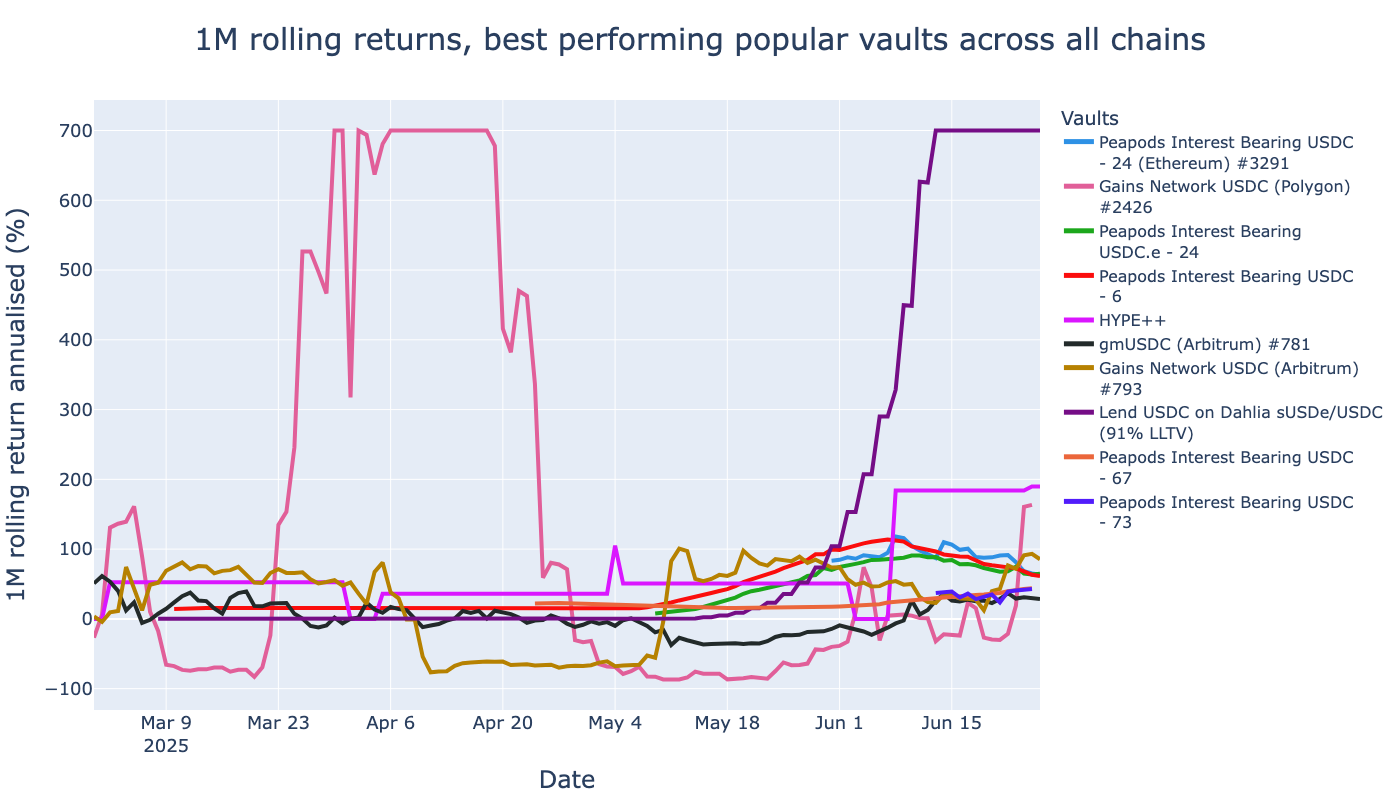

In [ ]:
# display(lifetime_data_filtered_df.head(2))

rolling_returns_df = calculate_rolling_returns(
    returns_df,
    filtered_vault_list_df=lifetime_data_filtered_df,
    clip_up=700,  # Clip up to 700% returns
)

fig = visualise_rolling_returns(
    rolling_returns_df,
    title="1M rolling returns, best performing popular vaults across all chains",
)
fig.show()

### Best performing popular vaults wo/volatile, chart

- Remove volatile vaults to focus on delta neutral vaults



Volatility min: 0.0000, max: 0.2466


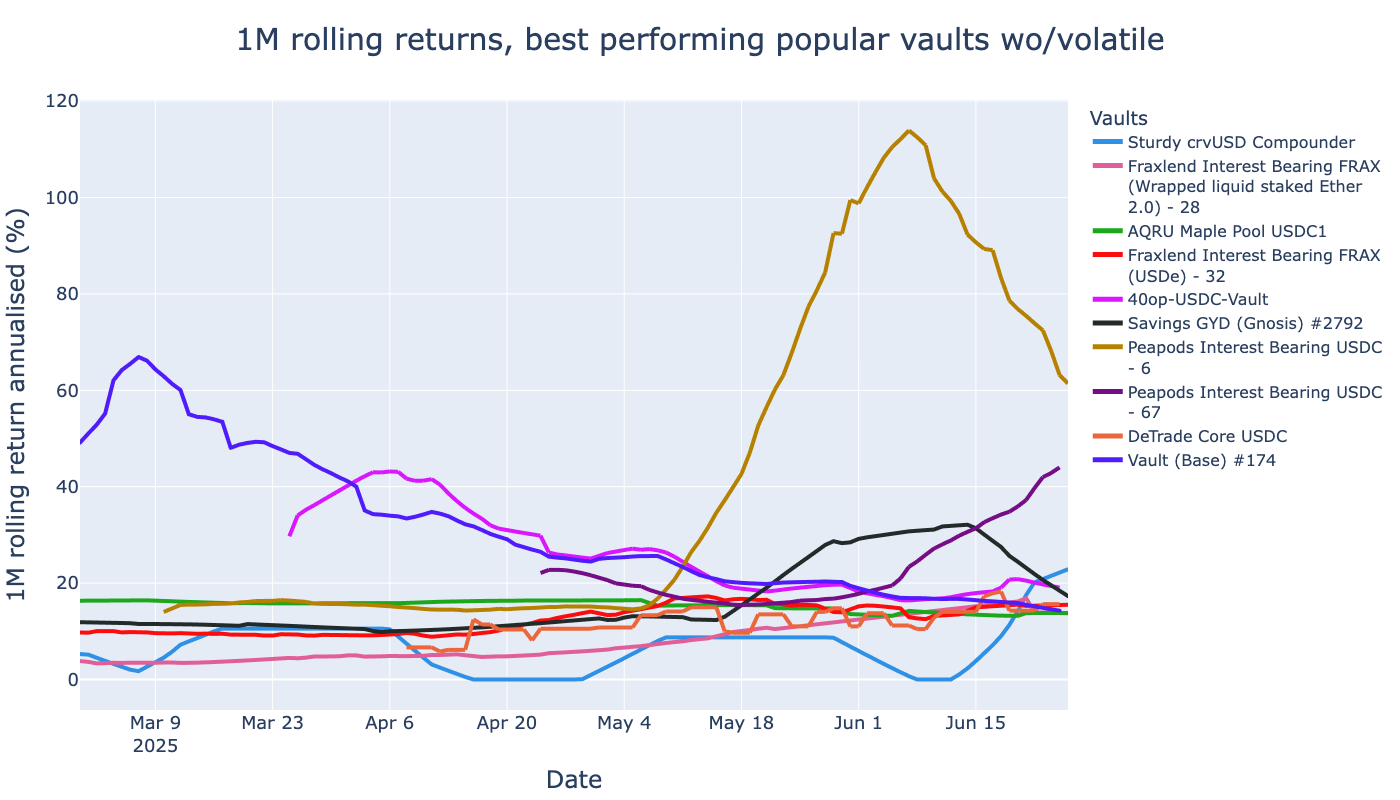

In [ ]:
print(f"Volatility min: {lifetime_data_filtered_df['three_months_volatility'].min():.4f}, max: {lifetime_data_filtered_df['three_months_volatility'].max():.4f}")

non_volatile_df = lifetime_data_filtered_df[lifetime_data_filtered_df["three_months_volatility"] < 0.001]

# display(non_volatile_df)

rolling_returns_df = calculate_rolling_returns(
    returns_df,
    filtered_vault_list_df=non_volatile_df,
    clip_up=700,  # Clip up to 700% returns
)

fig = visualise_rolling_returns(
    rolling_returns_df,
    title="1M rolling returns, best performing popular vaults wo/volatile",
)
fig.show()

### Best performing vaults by a chain

- Take 5 top vaults from each 
- TVL filter applied

In [ ]:
nav_threshold = 100_000
event_threshold = 10

lifetime_data_filtered_df = lifetime_data_df[(lifetime_data_df["current_nav"] >= nav_threshold) & (lifetime_data_df["event_count"] >= event_threshold)]


# Get top 5 vaults by one_month_returns for each chain with ranking
def get_top_vaults_by_chain(df, metric_column="one_month_cagr", top_n=5):
    result_dfs = []

    df = df.reset_index()

    for chain in df["chain"].unique():
        chain_df = df[df["chain"] == chain].copy()

        # Sort by the metric in descending order
        chain_df = chain_df.sort_values(by=metric_column, ascending=False)

        # Take top N entries
        top_chain_df = chain_df.head(top_n).copy()

        result_dfs.append(top_chain_df)

    # Combine all chains
    combined_df = pd.concat(result_dfs, ignore_index=True)

    return combined_df


# Get top 5 vaults by one_month_cagr for each chain
top_vaults_by_chain_df = get_top_vaults_by_chain(lifetime_data_filtered_df, metric_column="one_month_cagr", top_n=5)

display(top_vaults_by_chain_df.head(3))

# For chain comparison, we order a bit differently
CHAIN_COMPARISON_COLUMNS = [
    "Chain",
    "Protocol",
    "Vault",
    "Last 1M return annualised",
    "Lifetime return",
    "Current TVL USD",
    "Age (years)",
    "Denomination",
]


top_vaults_by_chain_df = top_vaults_by_chain_df.sort_values(by=["chain", "one_month_cagr"], ascending=[True, False])
sorted_df = format_lifetime_table(top_vaults_by_chain_df)
markdown_df = format_markdown_table(sorted_df, BLOG_POST_COLUMNS)
markdown_df = markdown_df[CHAIN_COMPARISON_COLUMNS]
print(markdown_df.to_markdown(index=False, tablefmt="pipe", floatfmt=",.2f"))

name  cagr  lifetime_return  \
0          Lend USDC on Dahlia sUSDe/USDC (91% LLTV)  1.33             0.38   
1  Concrete USDe MultiSig Strategy (Berachain) #3420  0.18             0.02   
2                            Concrete-BeraUSDe-Vault  0.17             0.02   

   three_months_cagr  one_month_cagr  three_months_volatility denomination  \
0               2.68           35.51                     0.01       USDC.e   
1               0.18            0.31                     0.00         USDe   
2               0.17            0.29                     0.00         USDe   

       chain     peak_nav  current_nav  years  mgmt_fee  perf_fee  \
0  Berachain   654,899.40   159,726.56   0.38       NaN       NaN   
1  Berachain 6,376,098.45   903,905.41   0.13       NaN       NaN   
2  Berachain 6,376,098.45   903,905.41   0.13       NaN       NaN   

   event_count            protocol  \
0       422.00  <unknown ERC-4626>   
1       444.00  <unknown ERC-4626>   
2       455.00  <unknown ERC-4626>   

                                                 id  three_months_returns  \
0  80094-0x50e394b94d7d40edff1481506542e5d4931c7a05                  0.38   
1  80094-0x4ab370bb847fcc1d742d792f1bf2aff458af7c61                  0.02   
2  80094-0x585934afbf1fa9f563b80283f8b916dd8f66a9b6                  0.02   

   one_month_returns start_date   end_date  
0               0.34 2025-05-27 2025-06-26  
1               0.02 2025-05-27 2025-06-26  
2               0.02 2025-05-27 2025-06-26

| Chain                                  | Protocol        | Vault                                                                                                                          | Last 1M return annualised   | Lifetime return   |   Current TVL USD |   Age (years) | Denomination   |
|:---------------------------------------|:----------------|:-------------------------------------------------------------------------------------------------------------------------------|:----------------------------|:------------------|------------------:|--------------:|:---------------|
| [Arbitrum](https://arbitrum.io)        |                 | [HYPE++](https://routescan.io/address/0x75288264fdfea8ce68e6d852696ab1ce2f3e5004)                                              | 194.32%                     | 31.20%            |      5,008,481.20 |          0.59 | USDC           |
| [Arbitrum](https://arbitrum.io)        |                 | [Gains Network USDC (Arbitrum) #793](https://routescan.io/ad

### Best-performing large vaults (min $2M TVL), list


In [ ]:
nav_threshold = 2_000_000
event_threshold = 10

lifetime_data_filtered_df = lifetime_data_df[(lifetime_data_df["current_nav"] >= nav_threshold) & (lifetime_data_df["event_count"] >= event_threshold)]

positive_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df["lifetime_return"] > 0]
negative_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df["lifetime_return"] <= 0]

print(f"All vaults sorted by lifetime returns and having currnet NAV > ${nav_threshold:,} USD")
print(f"Vaults with positive returns {len(positive_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")
print(f"Vaults with negative returns {len(negative_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")

lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(by="three_months_cagr", ascending=False)

column_to_shift = "three_months_cagr"
new_order = [column_to_shift] + [col for col in lifetime_data_filtered_df.columns if col != column_to_shift]
lifetime_data_filtered_df = lifetime_data_filtered_df[new_order]

sorted_df = format_lifetime_table(lifetime_data_filtered_df.head(50))
markdown_df = format_markdown_table(sorted_df, BLOG_POST_COLUMNS)
print(markdown_df.to_markdown(index=True, tablefmt="pipe", floatfmt=",.2f"))

All vaults sorted by lifetime returns and having currnet NAV > $2,000,000 USD
Vaults with positive returns 217 out of 233 total vaults
Vaults with negative returns 16 out of 233 total vaults
|    | Vault                                                                                                                              | Last 1M return annualised   | Lifetime return   |   Current TVL USD |   Age (years) | Denomination   | Chain                                  | Protocol        |
|---:|:-----------------------------------------------------------------------------------------------------------------------------------|:----------------------------|:------------------|------------------:|--------------:|:---------------|:---------------------------------------|:----------------|
|  1 | [HYPE++](https://routescan.io/address/0x75288264fdfea8ce68e6d852696ab1ce2f3e5004)                                                  | 194.32%                     | 31.20%            |      5,008,481.

### Best-performing large vaults (min $2M TVL), chart 


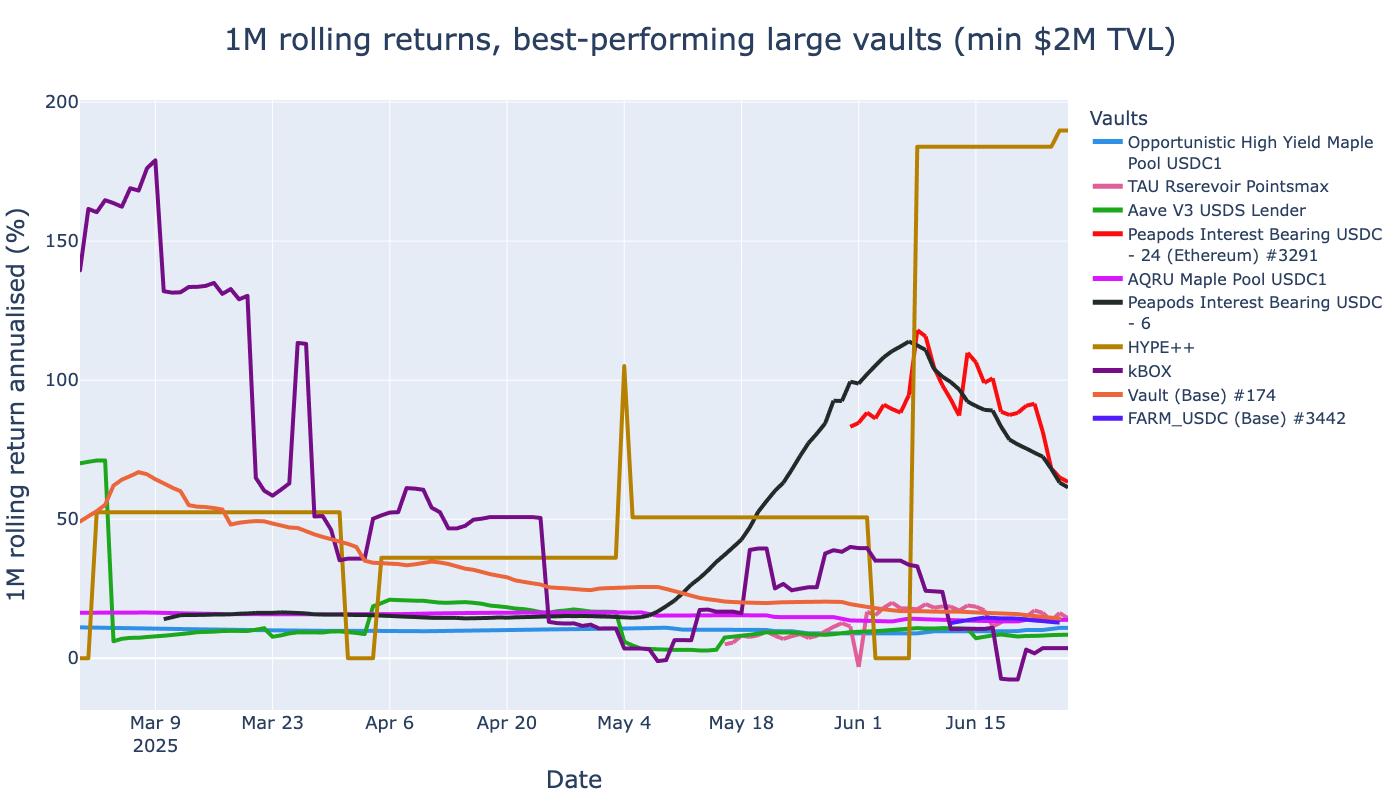

In [ ]:
rolling_returns_df = calculate_rolling_returns(
    returns_df,
    filtered_vault_list_df=lifetime_data_filtered_df,
    clip_up=700,  # Clip up to 700% returns
)

# display(rolling_returns_df.head(3))
# display(rolling_returns_df.tail(3))

fig = visualise_rolling_returns(
    rolling_returns_df,
    title="1M rolling returns, best-performing large vaults (min $2M TVL)",
)
fig.show()

### Best-performing large vaults, non-volatile, chart

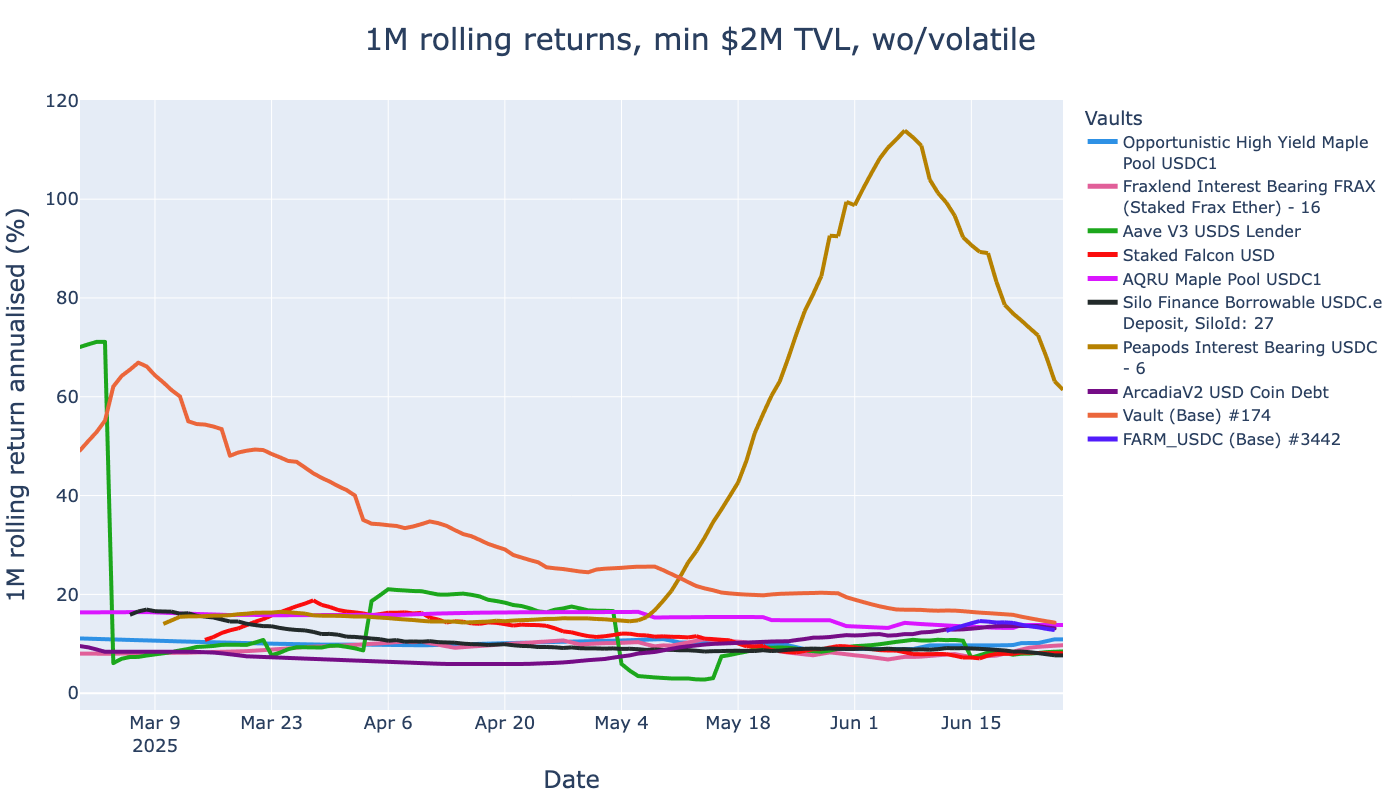

In [ ]:
non_volatile_df = lifetime_data_filtered_df[lifetime_data_filtered_df["three_months_volatility"] < 0.001]

# display(non_volatile_df)

rolling_returns_df = calculate_rolling_returns(
    returns_df,
    filtered_vault_list_df=non_volatile_df,
    clip_up=700,  # Clip up to 700% returns
)

fig = visualise_rolling_returns(
    rolling_returns_df,
    title="1M rolling returns, min $2M TVL, wo/volatile",
)
fig.show()

### Best performing new vaults

- Vaults less than two months old
- Have more than USD 15k in deposits
- Have more than 10 depositors

In [ ]:
nav_threshold = 15_000
event_threshold = 10
age_threshold = 2 / 12  # Two months

lifetime_data_filtered_df = lifetime_data_df[(lifetime_data_df["current_nav"] >= nav_threshold) & (lifetime_data_df["event_count"] >= event_threshold) & (lifetime_data_df["years"] <= age_threshold)]

positive_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df["lifetime_return"] > 0]
negative_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df["lifetime_return"] <= 0]

lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(by="one_month_cagr", ascending=False)

column_to_shift = "three_months_cagr"
new_order = [column_to_shift] + [col for col in lifetime_data_filtered_df.columns if col != column_to_shift]
lifetime_data_filtered_df = lifetime_data_filtered_df[new_order]

sorted_df = format_lifetime_table(lifetime_data_filtered_df.head(50))
markdown_df = format_markdown_table(sorted_df, BLOG_POST_COLUMNS)
print(markdown_df.to_markdown(index=True, tablefmt="pipe", floatfmt=",.2f"))

|    | Vault                                                                                                                          | Last 1M return annualised   | Lifetime return   |   Current TVL USD |   Age (years) | Denomination   | Chain                                  | Protocol         |
|---:|:-------------------------------------------------------------------------------------------------------------------------------|:----------------------------|:------------------|------------------:|--------------:|:---------------|:---------------------------------------|:-----------------|
|  1 | [Peapods Interest Bearing USDC.e - 27](https://routescan.io/address/0x1e7b137f08d718f2378872d3aa6d3dd47eee1191)                | 355.76%                     | 14.00%            |         18,831.27 |          0.12 | USDC.e         | [Sonic](https://sonic.so)              | Peapods          |
|  2 | [Peapods Interest Bearing USDC - 24 (Ethereum) #3291](https://routescan.io/address/0xc441d0bd70d

## All vaults

- Display all vaults included in this benchmark, sorted by TVL

In [ ]:
lifetime_data_filtered_df = lifetime_data_df.sort_values("current_nav", ascending=False)
lifetime_data_filtered_df = lifetime_data_filtered_df[lifetime_data_filtered_df["current_tvl"] >= 50.0]
sorted_df = format_lifetime_table(lifetime_data_filtered_df)
markdown_df = format_markdown_table(sorted_df, BLOG_POST_COLUMNS)
print(markdown_df.to_markdown(index=True, tablefmt="pipe", floatfmt=",.2f"))

|      | Vault                                                                                                                                                                | Last 1M return annualised   | Lifetime return   |   Current TVL USD |   Age (years) | Denomination   | Chain                                  | Protocol         |
|-----:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------|:----------------------------|:------------------|------------------:|--------------:|:---------------|:---------------------------------------|:-----------------|
|    1 | [Staked USDe (Ethereum) #1518](https://routescan.io/address/0x9d39a5de30e57443bff2a8307a4256c8797a3497)                                                              | 5.67%                       | 17.83%            |  3,169,350,438.57 |          1.59 | USDe           | [Ethereum](https://ethereum.org)       |   